## Inference

### Imports

In [1]:
import argparse
import numpy as np
import torch
import glob as glob
import pandas as pd
import os
import albumentations as A
import time
from albumentations.pytorch import ToTensorV2
from torch.nn import functional as F
from torch import topk
import torchvision.models as models
import torch.nn as nn
import cv2
import shutil

In [2]:
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

### Functions

In [3]:
class ChannelReducer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ChannelReducer, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        
    def forward(self, x):
        return self.conv(x)

In [4]:
def create_canny_edge_images(input_data_dir, output_dir_name):
    output_path = os.path.join("temp_output",output_dir_name)
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.mkdir(output_path)
    print(f"Created directory: {output_path}")
    
    # for each file in the input_data_dir, create the canny edge map of the input
    files = sorted(os.listdir(input_data_dir))  # Sort files to maintain order
    files = os.listdir(input_data_dir)
    for file in files:
        image = cv2.imread(os.path.join(input_data_dir, file))
        grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert image to grayscale
        blurred = cv2.GaussianBlur(grayscale, (5,5), 0) # apply Gaussian blur
        canny = cv2.Canny(blurred, 30, 150)
        cv2.imwrite(os.path.join(output_path, file), canny)

In [5]:
# Trying out create_canny_edge_images
input_data_dir = "temp"
output_dir_name = "temp_putput"
create_canny_edge_images(input_data_dir, output_dir_name)

Created directory: temp_output/temp_putput


In [6]:
dir_name = "temp"
image_1 = "00000.png"
rgb_image =  cv2.imread(os.path.join(dir_name,image_1))
canny_image =  cv2.imread(os.path.join(dir_name,image_1), cv2.IMREAD_GRAYSCALE)
canny_image = canny_image.reshape((canny_image.shape[0], canny_image.shape[1], -1))
concatenated_image = cv2.merge([rgb_image, canny_image])
print(f"rgb image dim: {rgb_image.shape}")
print(f"canny image dim: {canny_image.shape}")
print(f"concatenated image dim: {concatenated_image.shape}")

concatenated_image_tensor = torch.from_numpy(concatenated_image.transpose((2, 0, 1))).unsqueeze(0).float()
print(f"concatenated image tensor dim: {concatenated_image_tensor.shape}")

rgb image dim: (54, 53, 3)
canny image dim: (54, 53, 1)
concatenated image dim: (54, 53, 4)
concatenated image tensor dim: torch.Size([1, 4, 54, 53])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


output_tensor dim: torch.Size([1, 3, 53, 52])
out_image size is: (53, 52, 3)


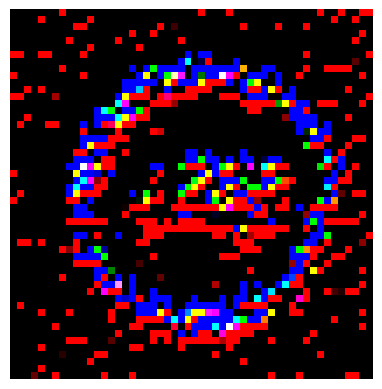

In [23]:
reducer = ChannelReducer(in_channels=4, out_channels=3, kernel_size=2)

output_tensor = reducer(concatenated_image_tensor)
print(f"output_tensor dim: {output_tensor.shape}")

# Showing Image
output_array = output_tensor.squeeze(0).detach().cpu().numpy()

# Convert the NumPy array to a cv2 image
output_image = np.transpose(output_array, (1, 2, 0))
output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)



import matplotlib.pyplot as plt
print(f"out_image size is: {output_image.shape}")
plt.imshow(output_image)

plt.axis('off')  # Optional: Turn off axis
plt.show()


In [ ]:
def build_model(pretrained=True, fine_tune=True, num_classes=10):
    model = models.mobilenet_v3_large(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
            
    model.classifier[3] = nn.Linear(in_features=1280, out_features=num_classes)

    return model

In [ ]:
def main(image_type):
    print("Capturing images of type:", image_type)
    if image_type == "original":
        pass
    elif image_type == "gaussian_blur":
        pass
    elif image_type == "pgd_attack":
        pass
    elif image_type == "fgsm_attack":
        pass
    else:
        pass
    
    device = torch.device("mps")
    
    sign_names_df = pd.read_csv('../PerturbedData/signnames.csv')
    class_names = sign_names_df.SignName.tolist()
    
    # DataFrame for ground truth.
    gt_df = pd.read_csv('../PerturbedData/GT-final_test.csv', delimiter=';')
    gt_df = gt_df.set_index('Filename', drop=True)
    
    
    model = build_model(pretrained=False,fine_tune=False, num_classes=43).to(device)
    model = model.eval()
    model.load_state_dict(torch.load('../outputs/MobileNetV3_model.pth', map_location=device)['model_state_dict'])
    
    # https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py
    def returnCAM(feature_conv, weight_softmax, class_idx):
        # Generate the class activation maps upsample to 256x256.
        size_upsample = (256, 256)
        bz, nc, h, w = feature_conv.shape
        output_cam = []
        for idx in class_idx:
            cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
            cam = cam.reshape(h, w)
            cam = cam - np.min(cam)
            cam_img = cam / np.max(cam)
            cam_img = np.uint8(255 * cam_img)
            output_cam.append(cv2.resize(cam_img, size_upsample))
        return output_cam

    def apply_color_map(CAMs, width, height, orig_image):
        for i, cam in enumerate(CAMs):
            heatmap = cv2.applyColorMap(cv2.resize(cam,(width, height)), cv2.COLORMAP_JET)
            result = heatmap * 0.5 + orig_image * 0.5
            result = cv2.resize(result, (224, 224))
        return result

    def visualize_and_save_map(result, orig_image, gt_idx=None, class_idx=None, save_name=None):
        # Put class label text on the result.
        if class_idx is not None:
            cv2.putText(result, f"Pred: {str(class_names[int(class_idx)])}", (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2, cv2.LINE_AA)
        if gt_idx is not None:
            cv2.putText(result, f"GT: {str(class_names[int(gt_idx)])}", (5, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2,cv2.LINE_AA)
        orig_image = cv2.resize(orig_image, (224, 224))
        img_concat = cv2.hconcat([np.array(result, dtype=np.uint8), np.array(orig_image, dtype=np.uint8)])
        cv2.imshow('Result', img_concat)
        cv2.waitKey(1)
        if save_name is not None:
            if image_type == "original":
                cv2.imwrite(f"outputs/test_results/original_imgs/CAM_{save_name}.jpg", img_concat)
            elif image_type == "gaussian_blur":
                cv2.imwrite(f"outputs/test_results/gaussian_blur/CAM_{save_name}.jpg", img_concat)
            elif image_type == "pgd_attack":
                cv2.imwrite(f"outputs/test_results/pgd_attack/CAM_{save_name}.jpg", img_concat)
            elif image_type == "fgsm_attack":
                cv2.imwrite(f"outputs/test_results/fgsm_attack/CAM_{save_name}.jpg", img_concat)
            else:
                cv2.imwrite(f"outputs/test_results/original_subset/CAM_{save_name}.jpg", img_concat)

    # Hook the feature extractor.
    # https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py
    features_blobs = []
    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())
        model._modules.get('features').register_forward_hook(hook_feature)
        # Get the softmax weight.
        params = list(model.parameters())
        weight_softmax = np.squeeze(params[-4].data.cpu().numpy())

        # Define the transforms, resize => tensor => normalize.
        transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
            ToTensorV2(),])
        
        counter = 0
        # Run for all the test images.
        if image_type == "original":
            all_images = glob.glob('../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/*.ppm')
        elif image_type == "gaussian_blur":
            all_images = glob.glob('../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/gaussian_blur/*.ppm')
        elif image_type == "pgd_attack":
            all_images = glob.glob('../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/pgd_attack/*.ppm')
        elif image_type == "fgsm_attack":
            all_images = glob.glob('../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/fgsm_attack/*.ppm')
        else:
            all_images = glob.glob('../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset/*.ppm')
        
        correct_count = 0
        frame_count = 0 # To count total frames.
        total_fps = 0 # To get the final frames per second. 
        for i, image_path in enumerate(all_images):
        # Read the image.
            image = cv2.imread(image_path)
            orig_image = image.copy()
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            height, width, _ = orig_image.shape
            # Apply the image transforms.
            image_tensor = transform(image=image)['image']
            # Add batch dimension.
            image_tensor = image_tensor.unsqueeze(0)
            
            
            #TODO: create canny edge image and concatenate on
            
            # Forward pass through model.
            start_time = time.time()
            outputs = model(image_tensor.to(device))
            end_time = time.time()
            # Get the softmax probabilities.
            probs = F.softmax(outputs).data.squeeze()
            # Get the class indices of top k probabilities.
            class_idx = topk(probs, 1)[1].int()
            # Get the ground truth.
            image_name = image_path.split(os.path.sep)[-1]
            gt_idx = gt_df.loc[image_name].ClassId
            # Check whether correct prediction or not.
            if gt_idx == class_idx:
                correct_count += 1
            # Generate class activation mapping for the top1 prediction.
            CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)
            # File name to save the resulting CAM image with.
            save_name = f"{image_path.split('/')[-1].split('.')[0]}"
            # Show and save the results.
            result = apply_color_map(CAMs, width, height, orig_image)
            visualize_and_save_map(result, orig_image, gt_idx, class_idx, save_name)
            counter += 1
            print(f"Image: {counter}")
            # Get the current fps.
            fps = 1 / (end_time - start_time)
            # Add `fps` to `total_fps`.
            total_fps += fps
            # Increment frame count.
            frame_count += 1

        print(f"{image_type}:Total number of test images: {len(all_images)}")
        print(f"{image_type}:Total correct predictions: {correct_count}")
        print(f"{image_type}:Accuracy: {correct_count/len(all_images)*100:.3f}")

        # Close all frames and video windows.
        cv2.destroyAllWindows()
        # calculate and print the average FPS
        avg_fps = total_fps / frame_count
        print(f"Average FPS: {avg_fps:.3f}")

In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Specify the type of attack ")
    parser.add_argument("image_type", help="original, gaussian_blur, pgd_attack, fgsm_attack")
    parser.add_argument("dataset_path", help="specify where the data is located")
    args = parser.parse_args()
    main(args.image_type)